In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23
2017-08-23 00:00:00


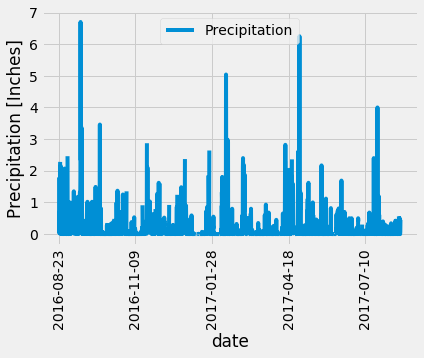

In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the last data listed in the data
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
# Calculate the date 1 year ago from the last data point in the database
last_year_date = (last_date - dt.timedelta(days=366))

# Perform a query to retrieve the data and precipitation scores
measurements= (Measurement.date, Measurement.prcp)
prcp_data = session.query(*measurements).\
            filter(Measurement.date >= last_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(prcp_data)
prcp_df=prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df=prcp_df.sort_index(ascending=True)
prcp_df=prcp_df.rename(columns={'prcp':'Precipitation'})

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=90);
ax.set_ylabel('Precipitation [Inches]');

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == station_counts[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

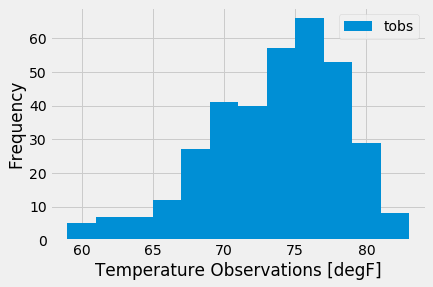

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
best_df =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == station_counts[0][0]).\
                    filter(Measurement.date > last_year_date).all()
best_df= pd.DataFrame(best_df)
best_df.plot(kind='hist',bins=12);
plt.xlabel('Temperature Observations [degF]')
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps=calc_temps('2017-01-01', '2017-01-07')
temps

[(62.0, 68.36585365853658, 74.0)]

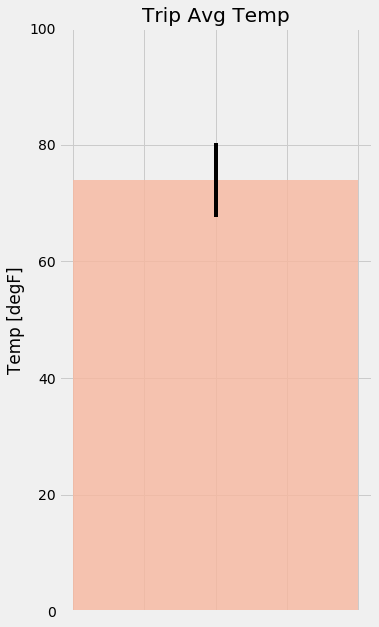

In [59]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(5, 10))
plt.bar(1,temps[0][2],yerr=temps[0][0]-temps[0][1],color=['#f7b79f'],alpha=.8)
plt.ylabel('Temp [degF]')
plt.title('Trip Avg Temp')
plt.ylim(0,100)
ax.set_xticklabels('')
plt.show()

In [67]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_data = session.query(*measurements).\
            filter(Measurement.date >= '2017-01-01',Measurement.date <= '2017-01-07').all()
total_rainfall_df=pd.DataFrame(prcp_data)
total_rainfall_df=total_rainfall_df.set_index('date')
total_rainfall_df=total_rainfall_df.groupby(['date']).sum()
total_rainfall_df

,prcp
date,
2017-01-01,0.35
2017-01-02,0.02
2017-01-03,0.00
2017-01-04,0.18
2017-01-05,0.95
2017-01-06,0.80
2017-01-07,0.06


In [114]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [128]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
start = dt.datetime.strptime('2017-01-01', '%Y-%m-%d')
end = dt.datetime.strptime('2017-01-07', '%Y-%m-%d')
delta = end-start
date_list = [start + dt.timedelta(days=x) for x in range(0, 1+delta.days)]

# Stip off the year and save a list of %m-%d strings
date_list = [f'{x:%m-%d}' for x in date_list]

# Loop through the list of %m-%d strings and calculate the normals for each date
date_normals=[(x,daily_normals(x)[0][0],daily_normals(x)[0][1],daily_normals(x)[0][2]) for x in date_list]
date_normals

[('01-01', 62.0, 69.15384615384616, 77.0),
 ('01-02', 60.0, 69.39622641509433, 77.0),
 ('01-03', 62.0, 68.9090909090909, 77.0),
 ('01-04', 58.0, 70.0, 76.0),
 ('01-05', 56.0, 67.96428571428571, 76.0),
 ('01-06', 61.0, 68.96491228070175, 76.0),
 ('01-07', 57.0, 68.54385964912281, 76.0)]

In [130]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df=pd.DataFrame(date_normals,columns=['date','min','average','max'])
normals_df=normals_df.set_index('date')
normals_df

,min,average,max
date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


Text(0, 0.5, 'Temp [degF]')

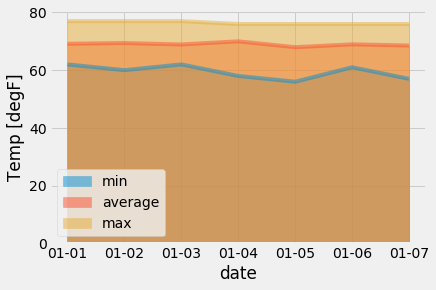

In [134]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False)
plt.ylabel('Temp [degF]')